Copyright **`(c)`** 2024 Giovanni Squillero `<giovanni.squillero@polito.it>`  
[`https://github.com/squillero/computational-intelligence`](https://github.com/squillero/computational-intelligence)  
Free under certain conditions — see the [`license`](https://github.com/squillero/computational-intelligence/blob/master/LICENSE.md) for details.  

In [57]:
import logging
from itertools import combinations
import pandas as pd
import numpy as np
from numpy.typing import NDArray
import geopy.distance

from tqdm.auto import tqdm
from icecream import ic

import os
import matplotlib.pyplot as plt
import cv2
import re

## Lab2 - TSP

https://www.wolframcloud.com/obj/giovanni.squillero/Published/Lab2-tsp.nb

https://en.wikipedia.org/wiki/Travelling_salesman_problem

# Setup

## Environment

In [58]:
IMG_FOLDER = 'imgs'
OUTPUT_PATH = 'out'
VIDEO_NAME = 'video.avi'

if not os.path.exists(IMG_FOLDER):
    os.makedirs(IMG_FOLDER)
else:
    for filename in os.listdir(IMG_FOLDER):
        file_path: str = os.path.join(IMG_FOLDER, filename)
    try:
        if os.path.isfile(file_path) or os.path.islink(file_path):
            os.unlink(file_path)
    except Exception as e:
        print('Failed to delete %s. Reason: %s' % (file_path, e))

if not os.path.exists(OUTPUT_PATH):
    os.makedirs(OUTPUT_PATH)

## Universe

In [59]:
CITIES: pd.DataFrame = (
    pd.read_csv('cities/vanuatu.csv', header=None, names=['name', 'lat', 'lon'])
    # sorting by lat and lon
    # TODO: consider sorting by relative distance, but this would immediately solve the TSP
    # so i guess I'm finding this with the algorithm below
    .sort_values(by=['lat', 'lon']).reset_index(drop=True)
)

NUM_CITIES: int = len(CITIES)
print(CITIES.head())
DIST_MATRIX: np.ndarray = np.zeros((len(CITIES), len(CITIES)), dtype=np.float64)
for c1, c2 in combinations(CITIES.itertuples(), 2):
    DIST_MATRIX[c1.Index, c2.Index] = DIST_MATRIX[c2.Index, c1.Index] = geopy.distance.geodesic(
        (c1.lat, c1.lon), (c2.lat, c2.lon)
    ).km

         name    lat     lon
0     Isangel -19.53  169.28
1        Vila -17.74  168.31
2    Lakatoro -16.09  167.40
3      Norsup -16.07  167.39
4  Luganville -15.51  167.15


# Plotting Cities Position

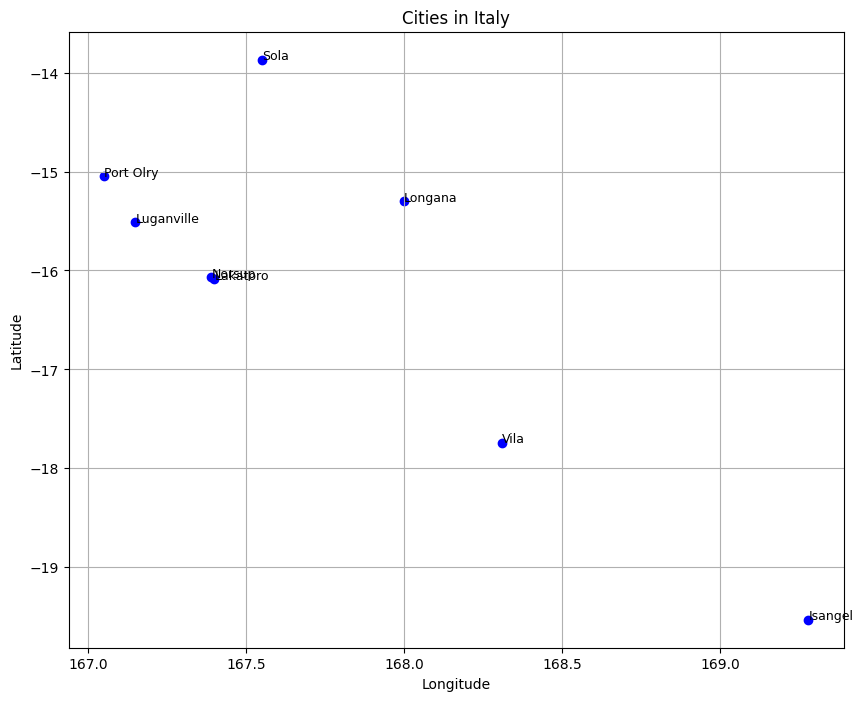

In [60]:
plt.figure(figsize=(10, 8))
plt.scatter(CITIES['lon'], CITIES['lat'], c='blue', marker='o')
for i, city in CITIES.iterrows():
    plt.text(city['lon'], city['lat'], city['name'], fontsize=9)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Cities in Italy')
plt.grid(True)
plt.show()

# Utility

In [61]:
def valid(solution: NDArray[np.int32] | list[int]) -> bool:
    # TODO: check if 0 is a valid index
    if np.isin(solution, -1).any() or solution[0] != solution[-1]:
        return False
    return len(set(solution)) == len(CITIES)


def cost(solution: NDArray[np.int32] | list[int]) -> np.float64:
    if not isinstance(solution, (list, np.ndarray)) and len(solution) < 1:
        raise ValueError(f"Solution wrong type: {type(solution)}")
    cumulative_dist: np.float64 = np.float64(0)
    if not valid(solution):
        return np.float64(np.inf)
    for c1, c2 in zip(solution, solution[1:]):
        cumulative_dist += np.float64(DIST_MATRIX[c1, c2])
    return cumulative_dist


# TODO: mutate inplace to avoid copying the genome and making the code more efficient
def mutation(individual: NDArray[np.int32]) -> NDArray[np.int32]:
    g1, g2 = -1, -1
    mutated_genome = individual.copy()
    # Avoid selecting index 0 and last
    high = len(individual)
    while g1 != g2:
        # TODO: add a probability to move different cities that are close to each other
        g1, g2 = np.random.randint(1, high, size=2)
    mutated_genome[g1], mutated_genome[g2] = mutated_genome[g2], mutated_genome[g1]
    # logging.debug(f"g1: {g1}\ng2: {g2}\nresult:{mutated_genome}")
    return mutated_genome


def get_top_k_parents(population: NDArray[np.int32], k: int = 2) -> NDArray[np.int32]:
    population_cost: NDArray[np.float64] = np.array([cost(individual) for individual in population])
    sorted_indices: NDArray[np.int32] = np.argsort(population_cost)

    sorted_population: NDArray[np.int32] = population[sorted_indices]
    return sorted_population[:k]


def xover(p1: NDArray[np.int32], p2: NDArray[np.int32], mutation_rate: float | None = None) -> NDArray[np.int32]:
    mask: NDArray[np.bool] = np.random.rand(len(p1)) < 0.5
    # Selecting index 0 and last of the parent 1 (could be parent 2 as well)
    mask[0] = mask[-1] = True
    child: NDArray[np.int32] = np.full(len(p1), -1, dtype=np.int32)
    child[mask] = p1[mask]
    for i in range(len(child)):
        p2_idx = 0
        # if an element is -1 it will find an element not already present from p2 to add to the child
        if child[i] == -1:
            for p2_idx in range(len(p2)):
                if p2[p2_idx] in child:
                    continue
                child[i] = p2[p2_idx]
                break

    # child = np.where(mask, p1.genome, p2.genome)

    if mutation_rate is not None and np.random.rand() < mutation_rate:
        child = mutation(child)

    assert valid(child), f"Invalid child: {child}\n p1: {p1}, \n p2:{p2}"

    return child

## Recreational Utility

### Saving PNGs

In [62]:
def save_solution(solution: list[int] | NDArray[np.int32], gen: int, display: bool = False) -> None:
    path_lons, path_lats = None, None
    if isinstance(solution, list):
        path_lons = [CITIES.iloc[city]['lon'] for city in solution]
        path_lats = [CITIES.iloc[city]['lat'] for city in solution]
    else:  # numpy array
        path_lons = [CITIES.iloc[city]['lon'] for city in solution]
        path_lats = [CITIES.iloc[city]['lat'] for city in solution]
    plt.figure(figsize=(10, 8))
    plt.scatter(CITIES['lon'], CITIES['lat'], c='blue', marker='o')
    for _, city in CITIES.iterrows():
        plt.text(city['lon'], city['lat'], city['name'], fontsize=9)
    plt.plot(path_lons, path_lats, c='blue', linestyle='-', linewidth=1, marker='o', markerfacecolor='red')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title(f'Best Travel Path - Generation {gen}')
    plt.grid(True)
    plt.savefig(f'{IMG_FOLDER}/gen_{gen}.png')
    if display:
        plt.show()
    plt.close()

### Making a video out of the PNGs

In [63]:
def sorted_alphanumeric(data):
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)', key)]
    return sorted(data, key=alphanum_key)


def make_video(img_folder: str = IMG_FOLDER, out_path: str = OUTPUT_PATH, video_name: str = VIDEO_NAME) -> None:
    images = [img for img in sorted_alphanumeric(os.listdir(img_folder)) if img.endswith(".png")]
    frame = cv2.imread(os.path.join(img_folder, images[0]))
    height, width, layers = frame.shape

    video = cv2.VideoWriter(f"{OUTPUT_PATH}/{video_name}", 0, 30, (width, height))

    for image in images:
        video.write(cv2.imread(os.path.join(img_folder, image)))

    cv2.destroyAllWindows()
    video.release()

# Solution

In [67]:
logging.basicConfig(format='%(levelname)s: %(message)s', level=logging.INFO)

POPULATION_SIZE = 500
MUTATION_RATE = 0.3
NUM_ELITES = 20

NUM_GENERATIONS = 2_000


population: NDArray[np.int32] = np.array([np.random.permutation(NUM_CITIES) for _ in range(POPULATION_SIZE)])
# considering one more cities for the circular path
# best_evolution: NDArray[np.int32] = np.zeros((NUM_GENERATIONS, NUM_CITIES + 1), dtype=np.int32)

# append first city at the end to make the path circular
first_city: NDArray[np.int32] = population[:, 0].reshape(-1, 1)
population = np.hstack((population, first_city))

for solution in population:
    assert valid(solution), f"Invalid individual: {solution}"


for gen in tqdm(range(NUM_GENERATIONS)):
    # best_evolution[gen, :] = population[np.argmin([cost(individual) for individual in population])]
    elites: NDArray[np.int32] = get_top_k_parents(population, NUM_ELITES)
    for n in range(NUM_ELITES):
        child: NDArray[np.int32] = xover(elites[n], elites[(n + 1) % NUM_ELITES], MUTATION_RATE).reshape(1, -1)
        # TODO: test if extra mutation chance
        # if np.random.rand() < MUTATION_RATE:
        #     child = mutation(child)
        population = np.append(population, child, axis=0)
    # TODO: consider allocating population as POPULATION_SIZE + NUM_ELITES/2 * NUM_GENERATIONS
    population = population[-POPULATION_SIZE:].copy()

best_traveler: NDArray[np.int32] = population[np.argmin([cost(individual) for individual in population])]
logging.info(
    f"result: Found a path of {len(best_traveler)-1} steps, total length {cost(best_traveler):.2f}km, valid: {valid(best_traveler)}"
)

# logging.info("Saving the evolution...")
# for gen in tqdm(range(NUM_GENERATIONS)):
#     save_solution(best_evolution[gen], gen)
save_solution(best_traveler, 0)

# logging.info("Rendering Video...")
# make_video()

  0%|          | 0/2000 [00:00<?, ?it/s]

INFO: result: Found a path of 8 steps, total length 1397.43km, valid: True


# Professor method

In [65]:
visited = np.full(len(CITIES), False)
dist = DIST_MATRIX.copy()
city = 0
visited[city] = True
tsp: list[int] = list()
tsp.append(int(city))
gen = 0
while not np.all(visited):
    dist[:, city] = np.inf
    closest = np.argmin(dist[city])
    visited[closest] = True
    city = closest
    tsp.append(int(city))
    # save_solution(tsp, gen)
    gen += 1

logging.debug(f"step: {CITIES.at[tsp[-1],'name']} -> {CITIES.at[tsp[0],'name']} ({DIST_MATRIX[tsp[-1],tsp[0]]:.2f}km)")
tsp.append(tsp[0])
# save_solution(tsp, gen)

logging.info(f"result: Found a path of {len(tsp)-1} steps, total length {cost(tsp):.2f}km")